 ## Task 2: Convergence


In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 20 16:54:47 2024

@author: aidanmcgregor
"""

# --- import des bibliothèques nécessaires ---
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import skew, kurtosis

# --- Paramètres globaux ---
m0 = 1.66e-27  # Masse atomique (kg)
K_40_mass = 40 * m0  # Masse atomique du potassium-40
kb = 1.3806e-23  # Constante de Boltzmann (J/K)
T = 30  # Température (K)

beta = 1 / (kb * T)  # Inverse de la température

# --- Définition des fonctions nécessaires ---
def target_pdf(eps, beta):
    """PDF cible f(ε)."""
    A = np.sqrt(beta / math.pi)
    return A * np.exp(-beta * eps) / np.sqrt(eps)

def rejection_sampling(N, beta):
    """Échantillonnage par rejet pour f(ε)."""
    lam = beta  # Choix de λ = β
    M = np.sqrt(np.pi / beta)  # Facteur d'échelle

    samples = []
    upper_bound = 2e-21
    while len(samples) < N:
        eps_proposed = np.random.gamma(0.5, 1 / lam)
        if eps_proposed < upper_bound:
            accept_prob = target_pdf(eps_proposed, beta) / (M * lam * np.exp(-lam * eps_proposed) / np.sqrt(eps_proposed))
            if np.random.rand() < accept_prob:
                samples.append(eps_proposed)
    return np.array(samples)

def compute_statistics(samples):
    """Calcule la moyenne, la variance, l'asymétrie et le kurtosis."""
    mean = np.mean(samples)
    variance = np.var(samples)
    skewness = skew(samples)
    kurt = kurtosis(samples, fisher=False)
    return mean, variance, skewness, kurt


a) Take Nexp = 1 and show the law of large numbers based on the data points you generated.

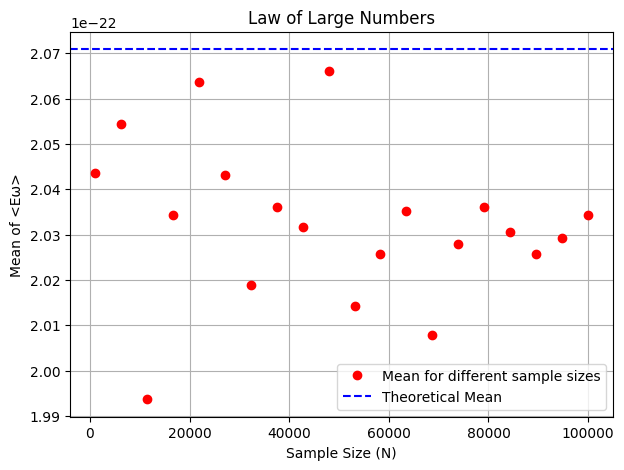

In [15]:
# Montrer la loi des grands nombres avec N_exp = 1

LLN_x = np.linspace(1000, 100000, 20)
LLN_y = [np.mean(rejection_sampling(int(n), beta)) for n in LLN_x]

plt.figure(figsize=(7, 5))
plt.plot(LLN_x, LLN_y, 'ro', label='Mean for different sample sizes')
plt.axhline(y=2.07090e-22, color='b', linestyle='--', label='Theoretical Mean')
plt.xlabel("Sample Size (N)")
plt.ylabel("Mean of <Eω>")
plt.title("Law of Large Numbers")
plt.legend()
plt.grid(True)
plt.show()

b) Take N_exp >> 1 and show the validity of the central limit theorem for <E_ω>.

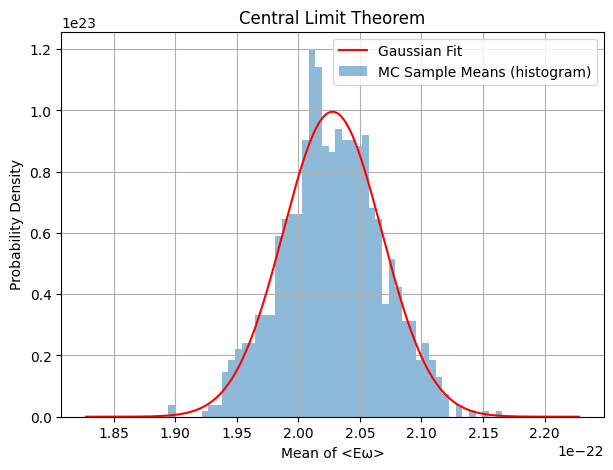

In [16]:
# Montrer la validité du théorème central limite avec N_exp ≫ 1

N_exp = 1000
sample_size = 5000
CLT_means = [np.mean(rejection_sampling(sample_size, beta)) for _ in range(N_exp)]

# Histogramme des moyennes
hist, bin_edges = np.histogram(CLT_means, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

plt.figure(figsize=(7, 5))
plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, label='MC Sample Means (histogram)')

# Comparaison avec une courbe gaussienne
CLT_mean = np.mean(CLT_means)
CLT_var = np.var(CLT_means)
CLT_x = np.linspace(CLT_mean - 5 * np.sqrt(CLT_var), CLT_mean + 5 * np.sqrt(CLT_var), 1000)
CLT_y = 1 / np.sqrt(2 * np.pi * CLT_var) * np.exp(-((CLT_x - CLT_mean) ** 2) / (2 * CLT_var))

plt.plot(CLT_x, CLT_y, 'r-', label='Gaussian Fit')
plt.xlabel("Mean of <Eω>")
plt.ylabel("Probability Density")
plt.title("Central Limit Theorem")
plt.legend()
plt.grid(True)
plt.show()

c) Compute the variance of <E_ω> and compare it with the value you expect.

In [17]:
# Calculer la variance de <Eω> et la comparer avec la valeur théorique


expected_variance = 2.3894658371069e-45  # Théorique: σ^2/N
empirical_variance = np.var(CLT_means)

print(f"The variance of <Eω> (empirical): {empirical_variance:.5e}")
print(f"The expected variance of <Eω>: {expected_variance:.5e}")


The variance of <Eω> (empirical): 1.60506e-47
The expected variance of <Eω>: 2.38947e-45
